# LMA data processing
---

## Overview
   
Within this notebook, we will cover:

1. General overview of xlma-python and its functionality
1. Reading data using xlma-python
1. Create a plot for conventional 2-D view of LMA data
1. Create an interactive 3D plot of the same data using PyVista-xarray

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic plotting |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Helpful | Basic arrays |
| [xlma-python](https://github.com/deeplycloudy/xlma-python/tree/master) | Helpful | Reading raw VHF LMA data
| [pyvista-xarray](https://github.com/pyvista/pyvista-xarray) | Helpful | 3D visuslization

- **Time to learn**: 45 minutes
---

### Imports

In [2]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import datetime
import xarray as xr
import glob

from pyxlma.plot.xlma_plot_feature import color_by_time, plot_points, setup_hist, plot_3d_grid, subset
from pyxlma.lmalib.io import read as lma_read
from pyxlma.plot.xlma import XlmaPlot

from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats
from pyxlma.lmalib.grid import  create_regular_grid, events_to_grid

import pyvista as pv
import pvxarray

pv.set_plot_theme("document")
pv.set_jupyter_backend("server")

%matplotlib inline
# from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


--------------------------------------------------------------------------------
   !!! You are currently using trame@3 which may break your application !!!
--------------------------------------------------------------------------------

 1. trame@3 only provides by default trame.widgets.[html,client] and remove
    everything else as implicit dependency. Those other widgets will still
    exist and will be supported, but they will need to be defined as a
    dependency of your application.

       $ pip install trame-vtk trame-vuetify trame-plot

### LMA data processing and visualization

 * An LMA network typically comprises six or more ground stations strategically installed over a circular region of roughly 60-km diameter.
 * Each station within the network measures the time of arrival (TOA) of radio waves in the very high frequency range (VHF; 60--66 MHz band) emitted during the leader stepping process as lightning channels develop in thunderstorms.
 * XLMA is a venerable IDL GUI program that displays VHF LMA data. It was originally written by New Mexico Tech in the late 1990s. xlma-python is an attempt to Pythonize the data processing and visualization pipeline used in XLMA.
 * The [xlma-python](https://github.com/deeplycloudy/xlma-python/tree/master) software is available on GitHub as open source software under an MIT license. Runs on Windows, Linux, OS X. xlma-python can be used to:
    * Reading raw LMA data in .dat.gz file format.
    * Sorting and clustering raw VHF LMA data.
    * Creating 2D and 3D gridded flash products.
    * Slice and visualize LMA data in a panel plot per custom saptio-temporal windows.
    * Convert raw LMA .dat file to an xarray dataset and write NetCDF files.

 * [PyVista](https://docs.pyvista.org/version/stable/) is:
    * Pythonic VTK: a high-level API to the Visualization Toolkit (VTK)
    * mesh data structures and filtering methods for spatial datasets
    * 3D plotting made simple and built for large/complex data geometries

 * [PyVista-xarray](https://github.com/pyvista/pyvista-xarray) is a collection of xarray DataArray accessors for PyVista to visualize datasets in 3D.

 * Both xlma-python and PyVista-xarray rely on xarray as the core data structure for data processing and visusalization.

### Read raw LMA data file

In [5]:
files_grabbed = sorted(glob.glob('../../data/L*'))
lma_data, starttime = lma_read.dataset(files_grabbed)
print(starttime)

2013-05-19 21:30:00


In [6]:
lma_data

<xarray.Dataset>
Dimensions:                      (number_of_stations: 18,
                                  number_of_events: 585674)
Dimensions without coordinates: number_of_stations, number_of_events
Data variables: (12/19)
    network_center_latitude      float64 35.28
    network_center_longitude     float64 -97.92
    network_center_altitude      float64 417.9
    station_latitude             (number_of_stations) float32 35.0 ... 34.71
    station_longitude            (number_of_stations) float32 -97.91 ... -99.08
    station_altitude             (number_of_stations) float32 339.1 ... 427.9
    ...                           ...
    event_power                  (number_of_events) float32 6.7 7.9 ... 12.2
    event_mask                   (number_of_events) uint32 1421 1421 ... 3461
    event_stations               (number_of_events) uint8 6 6 6 6 7 ... 6 7 7 6
    event_chi2                   (number_of_events) float32 0.18 0.14 ... 0.08
    event_id                     (number_of_events) uint64 0 1 ... 585672 585673
    event_contributing_stations  (number_of_events, number_of_stations) uint8 ...
Attributes:
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_version:   10.11.1RT
    event_algorithm_name:      ./lma_analysis_v10.11.1RT -d 20130519 -t 21300...
    references:               
    production_date:          1970-01-01 00:00:00 +00:00
    comment:                  
    institution:              unknown
    flash_algorithm_version:  unknown
    production_site:          Default
    flash_algorithm_name:     unknown
    source:                   VHF Lightning Mapping Array
    history:                  LMA source file created  Thu Aug 29 09:45:58 2013

In [7]:
files_grabbed = list(sorted(glob.glob('../../data/L*')))
lma_data, starttime = lma_read.dataset(files_grabbed)
# print(files_grabbed)

# lma_data, starttime = lma_read.dataset(['/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.dat.gz'])

# lf = read.lmafile(files_grabbed[-1])
# Station info comes from the last file read.
# stations = lma_file.stations

# Will need to add logic to check for existing data and do something else if it is
# if len(lma_data) > 0:
#     lma_data.sort_values('Datetime', inplace=True)

dttuple = [starttime, starttime+datetime.timedelta(minutes=10)]
# dttuple = lma_data.Datetime.min(), lma_data.Datetime.max()
tstring = 'LMA {}-{}'.format(dttuple[0].strftime('%H%M'),
                                      dttuple[1].strftime('%H%M UTC %d %B %Y '))
print(tstring, dttuple)

LMA 2130-2140 UTC 19 May 2013  [datetime.datetime(2013, 5, 19, 21, 30), datetime.datetime(2013, 5, 19, 21, 40)]


### Set spatial and temporal range to grid VHF data onto a grid

In [8]:
# Change the dictionaries below to a consistent set of coordinates
# and adjust grid_spatial_coords in the call to events_to_grid to 
# change what is gridded (various time series of 1D, 2D, 3D grids)

event_coord_names = {
    'event_latitude':'grid_latitude_edge',
    'event_longitude':'grid_longitude_edge',
#     'event_altitude':'grid_altitude_edge',
    'event_time':'grid_time_edge',
}

flash_ctr_names = {
    'flash_init_latitude':'grid_latitude_edge',
    'flash_init_longitude':'grid_longitude_edge',
#     'flash_init_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}
flash_init_names = {
    'flash_center_latitude':'grid_latitude_edge',
    'flash_center_longitude':'grid_longitude_edge',
#     'flash_center_altitude':'grid_altitude_edge',
    'flash_time_start':'grid_time_edge',
}

# Oklahoma
lat_range = (34.5, 36.5, 0.02)
lon_range = (-100, -98.01, 0.02)
alt_range = (0, 18e3, 1.0e3)

# Houston
# 29.7600000 -95.3700000
# lat_range = (27.75, 31.75, 0.025)
# lon_range = (-97.37, -93.37, 0.025)
# alt_range = (0, 18e3, 1.0e3)


grid_dt = np.asarray(60, dtype='m8[s]')
grid_t0 = np.asarray(dttuple[0]).astype('datetime64[ns]')
grid_t1 = np.asarray(dttuple[1]).astype('datetime64[ns]')
time_range = (grid_t0, grid_t1+grid_dt, grid_dt)

grid_edge_ranges ={
    'grid_latitude_edge':lat_range,
    'grid_longitude_edge':lon_range,
#     'grid_altitude_edge':alt_range,
    'grid_time_edge':time_range,
}
grid_center_names ={
    'grid_latitude_edge':'grid_latitude',
    'grid_longitude_edge':'grid_longitude',
#     'grid_altitude_edge':'grid_altitude',
    'grid_time_edge':'grid_time',
}

In [7]:
# Sort and cluster VHF data into flashes
ds = cluster_flashes(lma_data)
ds = flash_stats(ds)
# ds.to_netcdf('all_flashes.nc')

/Users/ms/mambaforge/envs/lightning-cookbook-dev/lib/python3.11/site-packages/pyxlma/coords.py:81: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  projectedData = array(proj4.transform(self.ERSlla, self.ERSxyz, lon, lat, alt ))


### Visualize gridded LMA data as a conventional 2D multi-panel plot


In [3]:
M2KM = 1000.0
xdiv = 0.01
ydiv = 0.01
zdiv = 0.1

try:
    alt_data = ds.event_altitude.values/M2KM
    lon_data = ds.event_longitude.values
    lat_data = ds.event_latitude.values
    station_data = ds.event_stations.values
    stationmin = 6
    time_data = pd.Series(ds.event_time) # because time comparisons
    chi_data = ds.event_chi2.values
# # Or the pandas version
# try:
#     alt_data = lma_data['alt(m)']/M2KM
#     lon_data = lma_data.lon
#     lat_data = lma_data.lat
#     time_data = lma_data.Datetime
#     chi_data = lma_data['reduced chi^2']
except:
    alt_data = np.array([])
    lon_data = np.array([])
    lat_data = np.array([])
    time_data = np.array([])
    chi_data = np.array([])

In [9]:
plot_cmap = 'plasma'
plot_s = 5

# Make subset here / set defaults?
tlim = [starttime, starttime + datetime.timedelta(minutes=1)]

clat, clon = 35.26707931, -97.73839823
xlim = [clon-3.1, clon+3.1]
ylim = [clat-3.1, clat+3.1]
zlim = [0, 21]
xchi = 1

lon_set, lat_set, alt_set, time_set, selection = subset(lon_data, lat_data, alt_data, time_data, chi_data,
                                                        station_data,xlim, ylim, zlim, tlim, xchi,stationmin)

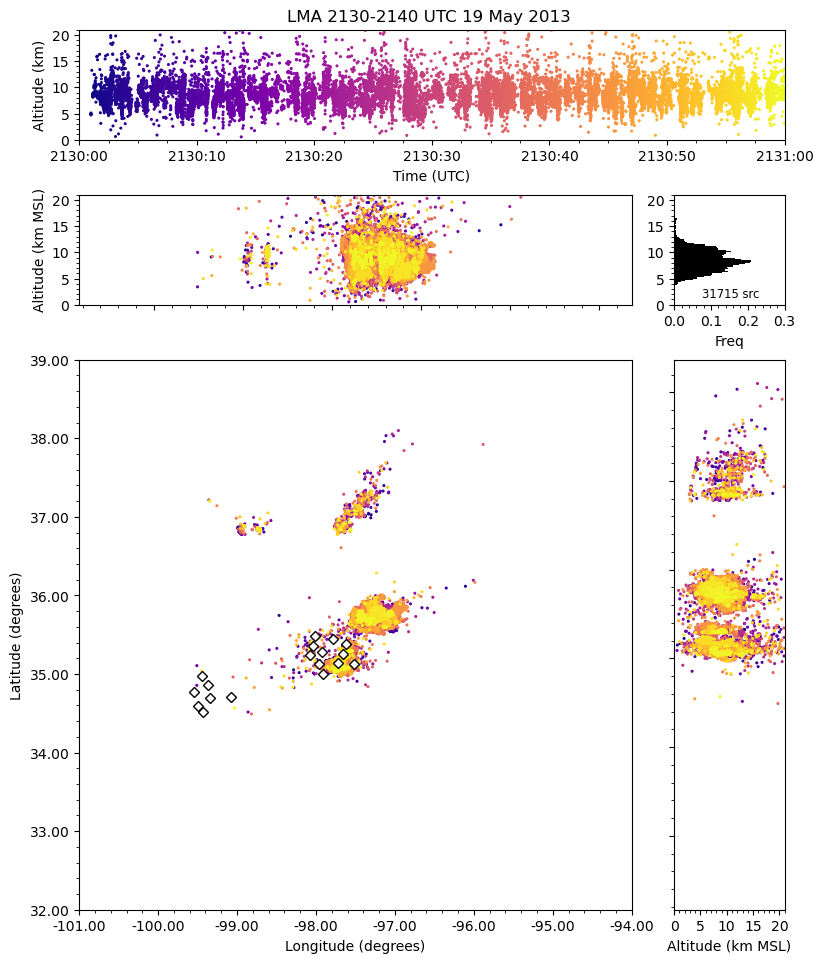

In [10]:
from pyxlma.plot.xlma_base_plot import subplot_labels, inset_view, BlankPlot

bk_plot = BlankPlot(tlim[0],bkgmap=False, 
              xlim=xlim, ylim=ylim, zlim=zlim, tlim=tlim, title=tstring)

# Add stations
stn_art = bk_plot.ax_plan.plot(ds['station_longitude'], 
                               ds['station_latitude'], 'wD', mec='k', ms=5)

if len(lon_set)==0:
    # If there is no data in the subset add "No Sources" to histogram panel
    bk_plot.ax_hist.text(0.02,1,'No Sources',fontsize=12)
else:
    # If there is data generate a by-time color map and plot the points
    plot_vmin, plot_vmax, plot_c = color_by_time(time_set, tlim)
    plot_points(bk_plot, lon_set, lat_set, alt_set, time_set,
                      plot_cmap, plot_s, plot_vmin, plot_vmax, plot_c)

plt.show()
# plt.savefig('./images/' + dttuple[0].strftime('%y%m%d') +
#             '/relampago_points_' + dttuple[0].strftime('%Y%m%d_%H%M.png'))

### Let's try to visualize the gridded data in 3D using PyVista xarray

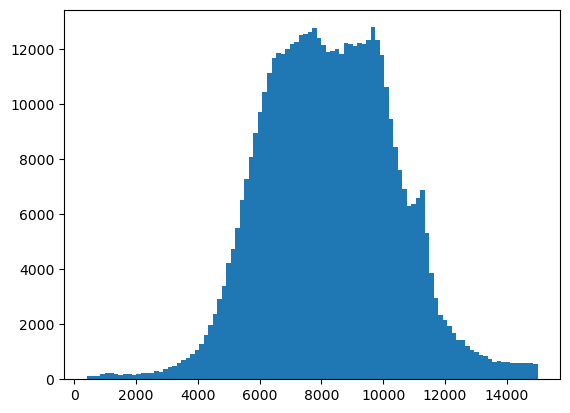

In [6]:
_ = plt.hist(ds.event_z, bins=100, range=(400, 15000))


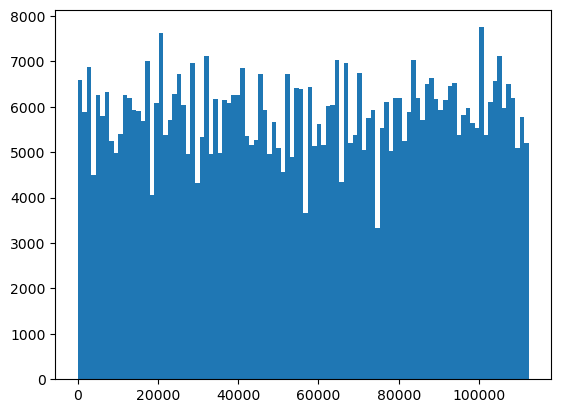

In [7]:
_ = plt.hist(ds.event_parent_flash_id, bins=100)


In [8]:
points = np.c_[ds.event_x, ds.event_y, ds.event_z]

t = pd.to_datetime(ds.event_time).astype(np.int64)


def get_flash(flash_index):
    flash_id = ds.event_parent_flash_id[flash_index]
    event_mask = ds.event_parent_flash_id == flash_id

    pc = pv.PolyData(points[event_mask])
    pc["event_time"] = t[event_mask]  # da.data
    pc["event_parent_flash_id"] = ds.event_parent_flash_id[event_mask]

    pc = pc.elevation().threshold((400, 15000), scalars="Elevation").extract_geometry()
    return pc


pc = pv.PolyData(points)
pc["event_time"] = t.values
pc["event_parent_flash_id"] = ds.event_parent_flash_id.values

full_pc = pc.elevation().threshold((400, 15000), scalars="Elevation")
box = full_pc.outline()

In [9]:
# flash with maximum number of events
max_event_flash = np.where(ds['flash_event_count'] == ds['flash_event_count'].max())

ds['flash_event_count'][max_event_flash]['flash_id'].compute()

<xarray.DataArray 'flash_id' (number_of_flashes: 1)>
array([43037], dtype=uint64)
Coordinates:
    flash_time_start      (number_of_flashes) datetime64[ns] 2013-05-19T21:34...
    flash_init_latitude   (number_of_flashes) float32 34.97
    flash_init_longitude  (number_of_flashes) float32 -97.61
    flash_init_altitude   (number_of_flashes) float32 9.887e+03
  * number_of_flashes     (number_of_flashes) uint64 43037
    flash_id              (number_of_flashes) uint64 43037

In [15]:
pc = get_flash(max_event_flash[0][0])

pl = pv.Plotter()
actor = pl.add_mesh(
    pc,
    scalars="event_time",
    cmap="plasma",
    point_size=10,
    ambient=0.5,
)
pl.set_background("grey")
pl.show()

Widget(value="<iframe src='http://localhost:65173/index.html?ui=P_0x17a368410_1&reconnect=auto' style='width: …

In [16]:
import ipywidgets as widgets
import pyvista as pv
from tqdm import tqdm

from pvxarray.vtk_source import PyVistaXarraySource


def time_controls(plotter: pv.BasePlotter, continuous_update=False, step=1):
    def update_time_index(time_index):
        ...
        plotter.add_mesh(
            get_flash(time_index),
            scalars="event_time",
            cmap="plasma",
            point_size=10,
            ambient=0.5,
            render_points_as_spheres=True,
            name="flash",
        )

        plotter.render()

    tmax = len(ds.event_time)

    def set_time(change):
        value = change["new"]
        if value < 0:
            value = 0
        if value >= tmax:
            value = tmax - 1
        update_time_index(value)

    play = widgets.Play(
        value=0,
        min=0,
        max=tmax,
        step=step,
        description="Time Index",
    )
    play.observe(set_time, "value")

    slider = widgets.IntSlider(min=0, max=tmax, continuous_update=continuous_update)
    widgets.jslink((play, "value"), (slider, "value"))
    return widgets.HBox([play, slider])


pl = pv.Plotter()
actor = pl.add_mesh(
    get_flash(43037),
    scalars="event_time",
    cmap="plasma",
    point_size=10,
    ambient=0.5,
    name="flash",
    render_points_as_spheres=True,
)
pl.add_mesh(box, color="k")
pl.set_background("grey")
pl.show()

Widget(value="<iframe src='http://localhost:65173/index.html?ui=P_0x17c5b7990_2&reconnect=auto' style='width: …

In [17]:
time_controls(pl, continuous_update=True)
